### 开始

In [1]:
# 检查Python版本
from sys import version_info
if version_info.major != 3:
    raise Exception('请使用Python3来完成此项目')

### 数据预处理

#### 获取数据
[Dogs vs. Cats Redux: Kernels Edition
](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

In [2]:
# download data and unzip it
# from urllib.request import urlretrieve
import subprocess
import os
from tqdm import tqdm
from zipfile import ZipFile

train_url = ['kaggle','competitions','download','-c','dogs-vs-cats-redux-kernels-edition',
            '-f','train.zip','-p','./']
test_url = ['kaggle','competitions','download','-c','dogs-vs-cats-redux-kernels-edition',
            '-f','test.zip','-p','./']
sample_csv_url = ['kaggle','competitions','download','-c','dogs-vs-cats-redux-kernels-edition',
                  '-f','sample_submission.csv','-p','./']


def download_unzip_dataset(url, zip_file_path, folder_path, unzip=True):
    if os.path.exists(zip_file_path):
        print("file is exist, no need download")
    else:
        print("download now")
#         urlretrieve(url, zip_file_path)
        subp = subprocess.run(url)
#         subp.wait()
    
    if unzip:
        if os.path.exists(folder_path):
            print("files found")
        else:
            print("unzip now")
            zipf = ZipFile(zip_file_path)
            zipf.extractall()
            print("unzip end")

download_unzip_dataset(train_url, 'train.zip', 'train/')
download_unzip_dataset(test_url, 'test.zip', 'test/')

file is exist, no need download
files found
file is exist, no need download
files found


#### 分离数据集，dog和cat图片分别放入train2/dogs, train2/cats

In [3]:
import os
import shutil

def split_train_set(old_dir, new_dir):
    file_list = os.listdir(old_dir)
    file_cats = filter(lambda x:x[:3] == 'cat', file_list)
    file_dogs = filter(lambda x:x[:3] == 'dog', file_list)

    if os.path.exists(new_dir):
        shutil.rmtree(new_dir)
    os.mkdir(new_dir)
    
    dogs_path = os.path.join(new_dir, 'dogs')
    cats_path = os.path.join(new_dir, 'cats')
    os.mkdir(dogs_path)
    os.mkdir(cats_path)
    
    # 此处要注意： os.symlink(src, dst)
    # dst是从它所在的目录去选择src,所以src必须是相对于dst的relative path
    for filename in file_cats:
        os.symlink('../../'+old_dir+filename, cats_path+'/'+filename)
    
    for filename in file_dogs:
        os.symlink(old_dir+filename, dogs_path+'/'+filename)
        
    print("split over")

split_train_set('train/', 'train2/')


split over


### Model Test

为了复用代码，同时也保证测试的一致性，将model的预测试封装为一个函数

In [3]:
from keras.preprocessing import image
# from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Input
import numpy as np


def trained_model_test(MODEL, image_size, preprocess_input, decode_predictions):
#     input_tensor = Input((image_size[0], image_size[1], 3)) # shape: width, height, channel
    
#     if preprocess_input:
#         x = preprocess(input_tensor)
#     else:
#         x = input_tensor
        
    # using the pre-training weights in ImageNet dataset
    base_model = MODEL(weights='imagenet')
    
    img = image.load_img('test/43.jpg', target_size=image_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    preds = base_model.predict(x)
    print('predicted:', decode_predictions(preds, top=3)[0])
    

- ResNet50

In [12]:
from keras.applications import resnet50

trained_model_test(resnet50.ResNet50, (224,224), resnet50.preprocess_input, resnet50.decode_predictions)

predicted: [('n02106550', 'Rottweiler', 0.9468535), ('n02089078', 'black-and-tan_coonhound', 0.024193374), ('n02107142', 'Doberman', 0.015099439)]


- Xception

In [17]:
from keras.applications import xception

trained_model_test(xception.Xception, (299,299), xception.preprocess_input, xception.decode_predictions)

predicted: [('n02106550', 'Rottweiler', 0.9479482), ('n02105412', 'kelpie', 0.0116197495), ('n02107142', 'Doberman', 0.006018338)]


- Inception V3

In [5]:
from keras.applications import inception_v3

trained_model_test(inception_v3.InceptionV3, (299,299), inception_v3.preprocess_input, inception_v3.decode_predictions)

predicted: [('n02106550', 'Rottweiler', 0.90469307), ('n02089078', 'black-and-tan_coonhound', 0.02317639), ('n02105412', 'kelpie', 0.010496103)]


### 构建模型

#### 单模型

In [9]:
## build model: xception + Dropout + Dense
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications import xception

# create the base pre-trained model
base_model = xception.Xception(input_tensor=Input((299, 299, 3)), weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False
    
# add a global spatial average pooling layer, use base_model'output as input
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)

# add a fully-connected layer
xout = Dense(1, activation='sigmoid')(x)

# this is the model will be train
model = Model(inputs=base_model.input, outputs = xout)

model.compile(optimizer='adadelta',
             loss='binary_crossentropy',
             metrics=['accuracy'])

#### 模型可视化

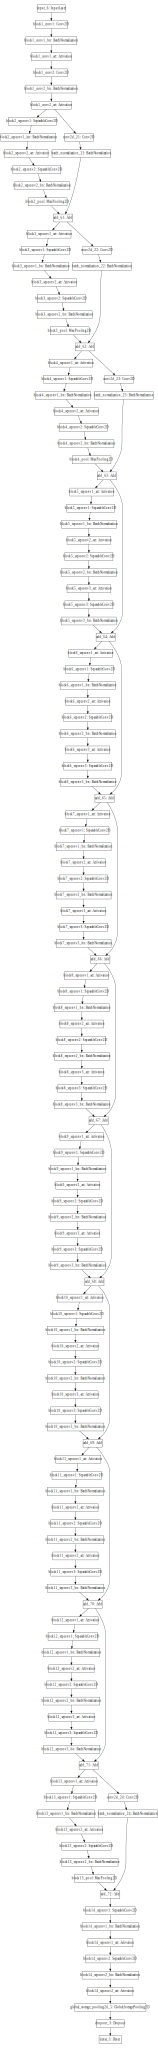

In [14]:
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

# plot_model(model, to_file='model.png', show_shapes='True')
SVG(model_to_dot(model).create(prog='dot',format='svg'))

### 准备训练集和测试集

In [16]:
from keras.preprocessing.image import *

image_size = (224,224)

image_gen = ImageDataGenerator()
train_generator = image_gen.flow_from_directory('train2', 
                                                target_size=image_size, 
                                                shuffle=False, 
                                                batch_size=16)
test_generator = image_gen.flow_from_directory('test', 
                                               target_size=image_size, 
                                               shuffle=False, 
                                               batch_size=16, 
                                               class_mode=None)


Found 25000 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


In [ ]:
# fit
model.fit_generator(train_generator,
                   steps_per_epoch=2000,
                   opochs=5,
                   validation_data=validation_generator,
                   validation_steps=800)